## Compare completeness with and without chipgaps, and at various levels of SNR. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Import the readOrbits function, etc from ProtoMakeObs
from ProtoMakeObs import readOrbits

In [2]:
def DiscoveryMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, 
                    nObsPerNight=2, tNight=90.*60.0, nNightsPerWindow=3, tWindow=15):
    # Given the observations for a particular object and the opsim metadata (join using joinObs)
    # Return the number possibilities for 'discovery' of the object, as a function of H
    # nObsPerNight = number of observations per night required for tracklet
    # tNight = max time start/finish for the tracklet (seconds)
    # nNightsPerWindow = number of nights with observations required for track
    # tWindow = max number of nights in track (days)
    gamma = 0.038
    eps = 1e-10
    discoveryChances = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return discoveryChances
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagDetect']
        # Calculate SNR, including approximate 'gamma' 
        xval = np.power(10, 0.4*(magObs-magLimitWithTrailing))
        snr = 1.0/np.sqrt((0.04-gamma)*xval + gamma*xval*xval)
        vis = np.where(snr>=snrLimit)[0]

        if len(vis) == 0:
            discoveryChances[i] = 0
        else:
            # Now to identify where observations meet the timing requirements.
            #  Identify visits where the 'night' changes. 
            visSort = np.argsort(ssoObs['night'])[vis]
            n = np.unique(ssoObs['night'][visSort])
            # Identify all the indexes where the night changes (swap from one night to next)
            nIdx = np.searchsorted(ssoObs['night'][visSort], n)
            # Add index pointing to last observation.
            nIdx = np.concatenate([nIdx, np.array([len(visSort)-1])])
            # Find the nights & indexes where there were more than nObsPerNight observations.
            obsPerNight = (nIdx - np.roll(nIdx, 1))[1:]
            nWithXObs = n[np.where(obsPerNight >= nObsPerNight)]
            nIdxMany = np.searchsorted(ssoObs['night'][visSort], nWithXObs)
            nIdxManyEnd = np.searchsorted(ssoObs['night'][visSort], nWithXObs, side='right') - 1
            # Check that nObsPerNight observations are within tNight
            timesStart = ssoObs['expMJD'][visSort][nIdxMany]
            timesEnd = ssoObs['expMJD'][visSort][nIdxManyEnd]
            # Identify the nights where the total time interval may exceed tNight 
            # (but still have a subset of nObsPerNight which are within tNight)
            check = np.where((timesEnd - timesStart > tNight) & (nIdxManyEnd + 1 - nIdxMany > nObsPerNight))[0]
            bad = []
            for i, j, c in zip(visSort[nIdxMany][check], visSort[nIdxManyEnd][check], check):
                t = ssoObs['expMJD'][i:j+1]
                dtimes = (np.roll(t, 1-nObsPerNight) - t)[:-1]
                if np.all(dtimes > tnight+eps):
                    bad.append(c)
            goodIdx = np.delete(visSort[nIdxMany], bad)
            # Now (with indexes of start of 'good' nights with nObsPerNight within tNight),
            # look at the intervals between 'good' nights (for tracks)
            if len(goodIdx) < nNightsPerWindow:
                discoveryChances[i] = 0
            else:
                dnights = (np.roll(ssoObs['night'][goodIdx], 1-nNightsPerWindow) - ssoObs['night'][goodIdx])
                discoveryChances[i] = len(np.where((dnights >= 0) & (dnights <= tWindow))[0])
    return discoveryChances

In [3]:
def Completeness(discoveryChances, Hrange, numSsos, requiredChances=1):
    completeness = np.zeros(len(Hrange), float)
    discoveries = discoveryChances.swapaxes(0, 1)
    for i, H in enumerate(Hrange):
        completeness[i] = np.where(discoveries[i] >= requiredChances)[0].size
    completeness = completeness/float(numSsos)
    return completeness

In [4]:
def integrateH(summaryVals, Hrange, Hindex=0.3):
    # Set expected H distribution. 
    # dndh = differential size distribution (number in this bin)
    dndh = np.power(10., Hindex*(Hrange-Hrange.min()))
    # dn = cumulative size distribution (number in this bin and brighter)
    dn = np.cumsum(dndh)
    intVals = np.cumsum(summaryVals*dndh)/dn
    return intVals

In [5]:
def metricVsH(metricVals, Hrange, npmethod=np.mean, label='Mean', fignum=None):
    fig = plt.figure(fignum)
    if npmethod is not None:
        vals = npmethod(metricVals, axis=0)
    else:
        vals = metricVals
    plt.plot(Hrange, vals, label=label)
    plt.xlabel('H (mag)')
    return fig.number

In [6]:
def metricVs2dOrbits(x, y, xlabel, ylabel, 
                     metricVals, units, Hval, Hrange,
                     xbins, ybins):
    xvals = x
    yvals = y
    nxbins = len(xbins)
    nybins = len(ybins)
    xbinsize = np.mean(np.diff(xbins))
    ybinsize = np.mean(np.diff(ybins))
    xmin = np.min(xbins)
    ymin = np.min(ybins)
    # Set up to calculate summary values at each x/y binpoint. 
    summaryVals = np.zeros((nybins, nxbins), dtype='float')
    summaryNums = np.zeros((nybins, nxbins), dtype='int')
    Hidx = np.where(Hrange == Hval)[0]
    # Metrics are evaluated in the order of the orbits. 
    for i, (xi, yi) in enumerate(zip(x, y)):
        xidx = np.min([int((xi - xmin)/xbinsize), nxbins-1])
        yidx = np.min([int((yi - ymin)/ybinsize), nybins-1])
        summaryVals[yidx][xidx] += metricVals[i][Hidx]
        summaryNums[yidx][xidx] += 1
    summaryVals = np.where(summaryNums != 0, summaryVals / summaryNums, 0)
    # Create 2D x/y arrays, to match 2D counts array.
    xi, yi = np.meshgrid(xbins, ybins)
    # Plot. 
    plt.figure()
    levels = np.arange(summaryVals.min(), summaryVals.max(), (summaryVals.max() - summaryVals.min())/200.0)
    levels = np.arange(0, 30, 1)
    plt.contourf(xi, yi, summaryVals, levels, extend='max', zorder=0)
    #plt.plot(orbits[xlabel], orbits[ylabel], 'k.', markersize=2, zorder=3)
    cbar = plt.colorbar()
    cbar.set_label(units)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

def metricVs2dOrbitsPoints(orbits, xlabel, ylabel, metricVals, Hval, Hrange, 
                           foregroundPoints=True, backgroundPoints=True):
    x = orbits[xlabel]
    y = orbits[ylabel]    
    Hidx = np.where(Hrange == Hval)[0]
    plt.figure()
    colors = np.swapaxes(metricVals, 0, 1)[Hidx][0]
    vmin = np.max(1, colors.min())
    if backgroundPoints:
        condition = np.where(colors == 0)
        plt.plot(x[condition], y[condition], 'r.', markersize=4, alpha=0.5, zorder=3)
    if foregroundPoints:
        plt.scatter(x, y, c=colors, vmin=vmin, s=15, alpha=0.8, zorder=0)
        cb = plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Read in data and calculate metric values. Then we'll plot.

In [109]:
orbitfile = 'pha20141031.des'
outroot = orbitfile.replace('.des', '').replace('.txt', '')

orbits = readOrbits(orbitfile)

ssoObs = {}

In [110]:
obsfile = 'pha_withChip_allObs.txt'
obs = pd.read_table(obsfile, sep='\s*', engine='python')
newcols = obs.columns.values
newcols[0] = 'objId'
obs.columns = newcols
ssoObs['chip'] = obs.to_records()

In [111]:
obsfile = 'pha_roundFOV_allObs.txt'
obs = pd.read_table(obsfile, sep='\s*', engine='python')
newcols = obs.columns.values
newcols[0] = 'objId'
obs.columns = newcols
ssoObs['round'] = obs.to_records()

In [112]:
obsfile = 'pha_halfroundFOV_allObs.txt'
obs = pd.read_table(obsfile, sep='\s*', engine='python')
newcols = obs.columns.values
newcols[0] = 'objId'
obs.columns = newcols
ssoObs['halfround'] = obs.to_records()

In [113]:
ssoID = 'objId'
ssoids = orbits[ssoID]
if len(ssoids) != len(np.unique(orbits[ssoID])):
    print "Orbit id's are repeated!"

In [59]:
# Run metrics with a variation in SNR
Hrange = np.arange(13, 27.2, 0.5)
sNum = float(len(ssoids))

# Set up to store metric results.
discoveries = {}
discoveries30 = {}
completeness = {}
completeness30 = {}
compH = {}
compH30 = {}
fovtypes = ['chip', 'round', 'halfround']
snrs = [3, 5, 8, 0.000001]
for c in fovtypes:
    discoveries[c] = {}
    discoveries30[c] = {}
    completeness[c] = {}
    completeness30[c] = {}
    compH[c] = {}
    compH30[c] = {}
    for snr in snrs:
        discoveries[c][snr] = np.zeros([len(ssoids), len(Hrange)], int)
        discoveries30[c][snr] = np.zeros([len(ssoids), len(Hrange)], int)
    
# Run Metrics.
alpha = 0.3
for i, sso in enumerate(ssoids):
    orbit = orbits[np.where(orbits[ssoID] == sso)]
    for c in fovtypes:
        obs = ssoObs[c][np.where(ssoObs[c][ssoID] == sso)]
        for snr in snrs:
            discoveries[c][snr][i] = DiscoveryMetric(obs, Hrange=Hrange, tWindow=15, snrLimit=snr)
            discoveries30[c][snr][i] = DiscoveryMetric(obs, Hrange=Hrange, tWindow=30, snrLimit=snr)        

# Run 'summary' stats (i.e. completeness over the whole population)
for c in fovtypes:
    for snr in snrs:
        completeness[c][snr] = Completeness(discoveries[c][snr], Hrange, sNum)
        completeness30[c][snr] = Completeness(discoveries30[c][snr], Hrange, sNum)
        compH[c][snr] = integrateH(completeness[c][snr], Hrange, Hindex=alpha)
        compH30[c][snr] = integrateH(completeness30[c][snr], Hrange, Hindex=alpha)

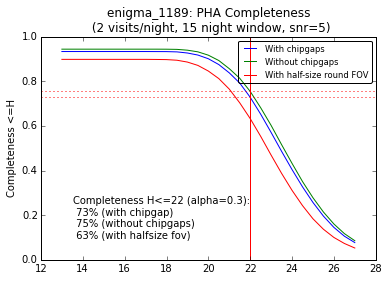

In [60]:
# Make plots. 
# Plot with/without chip gaps 
plt.plot(Hrange, compH['chip'][5], label='With chipgaps')
plt.plot(Hrange, compH['round'][5], label='Without chipgaps')
plt.plot(Hrange, compH['halfround'][5], label='With half-size round FOV')
plt.legend(loc='upper right', fancybox=True, fontsize='smaller')
plt.ylabel('Completeness <=H')
plt.title('enigma_1189: PHA Completeness\n (2 visits/night, 15 night window, snr=5)')
#completeness at H<=22
Hidx = np.where(Hrange==22.0)[0]
comp22_chip = compH['chip'][5][Hidx]
comp22_round = compH['round'][5][Hidx]
comp22_halfround = compH['halfround'][5][Hidx]
plt.axhline(comp22_chip, color='r', linestyle=':')
plt.axhline(comp22_round, color='r', linestyle=':')
plt.axvline(22, color='r')
txtstring = ('Completeness H<=22 (alpha=%.1f):\n %.0f%s (with chipgap) \n %.0f%s (without chipgaps)'
             %(alpha, comp22_chip*100, '%', comp22_round*100, '%'))
txtstring += ' \n %.0f%s (with halfsize fov)' %(comp22_halfround*100, '%')
plt.figtext(0.2, 0.2, txtstring)
plt.savefig('completeness_chipgaps.png', format='png')

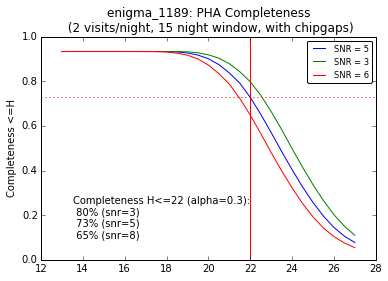

In [61]:
# Make plots. 
# with varying SNR
plt.plot(Hrange, compH['chip'][5], label='SNR = 5')
plt.plot(Hrange, compH['chip'][3], label='SNR = 3')
plt.plot(Hrange, compH['chip'][8], label='SNR = 6')
#plt.plot(Hrange, compH['chip'][0.000001], label='SNR ~ 0')
plt.legend(loc='upper right', fancybox=True, fontsize='smaller')
plt.ylabel('Completeness <=H')
plt.title('enigma_1189: PHA Completeness\n (2 visits/night, 15 night window, with chipgaps)')
#completeness at H<=22
Hidx = np.where(Hrange==22.0)[0]
comp22 = {}
comp22[3] = compH['chip'][3][Hidx]
comp22[5] = compH['chip'][5][Hidx]
comp22[8] = compH['chip'][8][Hidx]
plt.axhline(comp22[5], color='r', linestyle=':')
plt.axvline(22, color='r')
plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): \n %.0f%s (snr=3) \n %.0f%s (snr=5) \n %.0f%s (snr=8)'
            %(alpha, comp22[3]*100, '%', comp22[5]*100, '%', comp22[8]*100, '%'))
plt.savefig('completeness_snr.png', format='png')

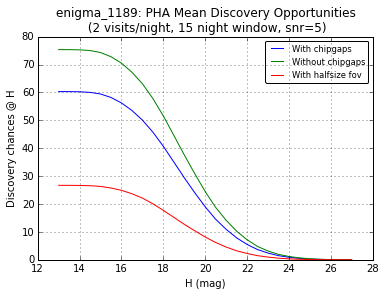

In [62]:
# Make plots. 
# Plot with/without chip gaps 
fignum = metricVsH(discoveries['chip'][5], Hrange, npmethod=np.mean, label='With chipgaps', fignum=None)
fignum = metricVsH(discoveries['round'][5], Hrange, npmethod=np.mean, label='Without chipgaps', fignum=fignum)
fignum = metricVsH(discoveries['halfround'][5], Hrange, npmethod=np.mean, label='With halfsize fov', fignum=fignum)
plt.legend(loc='upper right', fancybox=True, fontsize='smaller')
plt.title('enigma_1189: PHA Mean Discovery Opportunities\n (2 visits/night, 15 night window, snr=5)')
plt.ylabel('Discovery chances @ H')
plt.grid()
plt.savefig('meandiscovery_chipgaps.png', format='png')

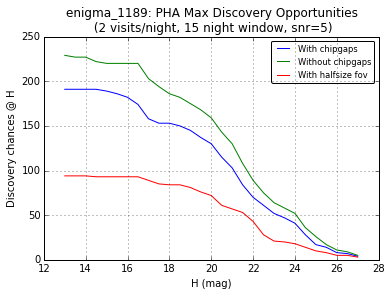

In [63]:
fignum = metricVsH(discoveries['chip'][5], Hrange, npmethod=np.max, label='With chipgaps', fignum=None)
fignum = metricVsH(discoveries['round'][5], Hrange, npmethod=np.max, label='Without chipgaps', fignum=fignum)
fignum = metricVsH(discoveries['halfround'][5], Hrange, npmethod=np.max, label='With halfsize fov', fignum=fignum)
plt.legend(loc='upper right', fancybox=True, fontsize='smaller')
plt.title('enigma_1189: PHA Max Discovery Opportunities\n (2 visits/night, 15 night window, snr=5)')
plt.ylabel('Discovery chances @ H')
plt.grid()
plt.savefig('maxdiscovery_chipgaps.png', format='png')

In [64]:
def snrMetric(ssoObs, magH=20., Hval=22.0):
    """
    Return the SNR values where an object is visible at a given magnitude.
    """
    gamma = 0.038
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    magObs = Hval - magH + ssoObs['magV'] + ssoObs['dmagColor']
    magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagDetect']
    # Calculate SNR, including approximate 'gamma' 
    xval = np.power(10, 0.4*(magObs-magLimitWithTrailing))
    snr = 1.0/np.sqrt((0.04-gamma)*xval + gamma*xval*xval)
    return snr

In [67]:
H = 22.0

snr = {}
for c in fovtypes:
    snr[c] = np.empty(len(ssoids), object)
    
for i, sso in enumerate(ssoids):
    orbit = orbits[np.where(orbits[ssoID] == sso)]
    for c in fovtypes:
        obs = ssoObs[c][np.where(ssoObs[c][ssoID] == sso)]
        for c in fovtypes:
            snr[c][i] = snrMetric(obs, Hval=H)

151 151
809 809
1243 1243
1281 1281


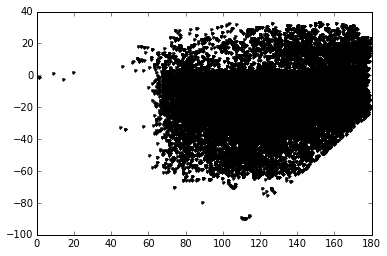

In [90]:
snrlimit = 5
for c in ['halfround']:#fovtypes:
    plt.figure()
    for i, sso in enumerate(ssoids):
        obs = ssoObs[c][np.where(ssoObs[c][ssoID] == sso)]
        elon = obs['solarelon'][np.where(snr[c][i] >= snrlimit)]
        dec = obs['dec'][np.where(snr[c][i] >= snrlimit)]
        if np.any(elon<40):
            print i, sso
        plt.plot(elon, dec, 'k.')    

In [115]:
obs = ssoObs[c][np.where(ssoObs[c][ssoID] == 151)]
condition = np.where(obs['solarelon'] <= 40.)
print obs.dtype.names
print obs[condition]
print zip(obs['ra'][condition], obs['dec'][condition], np.degrees(obs['fieldRA'][condition]), 
          np.degrees(obs['fieldDec'][condition]), obs['solarelon'][condition], obs['expMJD'][condition], 
          obs['objId'][condition])
# I doublecheck (in the Ephemeris Generation notebook) that the errors in 'obs' are small compared to the position
# predicted by oorb at the actual time. And also that this object is really at 8 deg solar elongation (according to oorb)
# opsim says the 'solar elongation' is 157 deg though. 
# I'm kind of thinking the pyoorb solar elongation is incorrect. 

('index', 'objId', 'delta', 'ra', 'dec', 'magV', 'time', 'dradt', 'ddecdt', 'phase', 'solarelon', 'velocity', 'obsHistID', 'expMJD', 'night', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 'finSeeing', 'fiveSigmaDepth', 'visitExpTime', 'dmagColor', 'dmagTrailing', 'dmagDetect')
[ (25647, 151, 1.8540402179700002, 150.40898911899998, 1.76884043354, 21.732599697399998, 51250.048523000005, 1.09816114183, 0.46905922546400003, 9.94506253161, 8.85092436056, 1.1941419096700001, 1286085, 51250.048523000005, 1897, 2.624318, 0.049506, 2.226131, 'r', 0.6912, 24.547131, 30.0, -0.172306859497, 0.390180212284, 0.648276486773)]
[(150.40898911899998, 1.7688404335400001, 150.36234550021319, 2.8364848605746538, 8.8509243605600005, 51250.048523000005, 151)]
